# Tutorial 4: Stereo-seq (mouse olfactory bulb)

This tutorial demonstrates how to identify spatial domains on the Stereo-seq platform.

In this tutorial, we foucs on the mouse olfactory bulb Stereo-seq data (https://github.com/JinmiaoChenLab/SEDR_analysiss). Before running the model, please download the input data via https://drive.google.com/drive/folders/1pV6u6U3JD8aTnBIGHEZdctZ0hZfWcBY1.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import time
import stGCL as stGCL
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import utils,train_model

In [2]:
section_id="Stereo-seq"
rad_cutoff = 70
k = 7
epoch = 1200
top_genes = 3000
use_image = False

In [3]:
adata = sc.read('/home/dell/stproject/stGCL/Data/Mouse_olfactory_bulb/adata.h5ad')
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata)

## Constructing the spatial network and Running model

In [4]:
utils.Cal_Spatial_Net(adata, rad_cutoff=rad_cutoff)

In [5]:
adata = train_model.train(adata,k,n_epochs=epoch,use_image=use_image)

train with no image
Epoch:100 loss:0.76813
Epoch:200 loss:0.73609
Epoch:300 loss:0.73474
Epoch:400 loss:0.73493
Epoch:500 loss:0.73991
Epoch:600 loss:0.73205
Epoch:700 loss:0.733
Epoch:800 loss:0.74741
Epoch:900 loss:0.73166
Epoch:1000 loss:0.73462
Epoch:1100 loss:0.73248
Epoch:1200 loss:0.73341


In [6]:
adata = utils.mclust_R(adata, used_obsm='stGCL', num_cluster=k)
adata.obs["stGCL"] = adata.obs['mclust']

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [7]:
coor = pd.DataFrame(adata.obsm['spatial'])
coor.index = adata.obs.index
coor.columns = ['imagerow', 'imagecol']
adata.obs["x_pixel"]=coor['imagerow']
adata.obs["y_pixel"]=coor['imagecol']

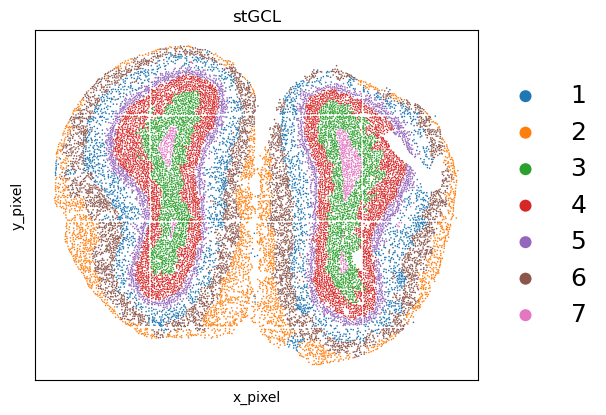

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
title = "stGCL"
ax = sc.pl.scatter(adata, alpha=1, x="x_pixel", y="y_pixel", color="stGCL", legend_fontsize=18, show=False,title=title,
                   size=100000 / adata.shape[0])
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
ax.axes.invert_yaxis()